## Keyphrase extraction from sociology papers
This notebook contains the efforts to extract crucial n-grams identifying the concept of Nation from some sociology papers published between the end of the 20th century and the beginning of the 21st century. The papers are in French (11 papers) and in German (4 papers)

In [1]:
# imports
import pandas as pd
import glob
from nltk.corpus import stopwords
import nltk 
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import spacy
import json
from PIL import Image
import wordcloud

In [2]:
#loading the data
french_txt = []

for file in glob.glob("data_sociology/french*.txt"):
    print(file)
    french_txt.append(open(file, "r", encoding='utf8').read())
    
german_txt = []

for file in glob.glob("data_sociology/german*.txt"):
    german_txt.append(open(file, "r", encoding='utf8').read())
    
print(len(french_txt), len(german_txt))

data_sociology\french-Babadzan.txt
data_sociology\french-DIECKHOFF.txt
data_sociology\french-gellner.txt
data_sociology\french-GODECHOT.txt
data_sociology\french-Hermet.txt
data_sociology\french-Ipperciel-2.txt
data_sociology\french-Ipperciel.txt
data_sociology\french-Ledermann.txt
data_sociology\french-racisme.txt
data_sociology\french-renans-rev.txt
data_sociology\french-swiss-nationality.txt
11 4


In [3]:
#loading the data
french_baseline = []
for file in glob.glob("baseline_sociology/french*.txt"):
    french_baseline.append(open(file, "r", encoding='utf8').read())
    
german_baseline = []

for file in glob.glob("baseline_sociology/german*.txt"):
    german_baseline.append(open(file, "r", encoding='utf8').read())
    
print(len(french_baseline), len(german_baseline))

11 4


### Preprocessing
- punctuation removal
- stopword removal
- (OPTIONAL) language filtering
- lemmatization
- part-of-speech tagging filtering

In [4]:
#english_vocab = set(w.lower() for w in nltk.corpus.words.words())
#text_vocab = set(w.lower() for w in ' '.join(french_txt+german_txt).split() if w.lower().isalpha())
#unusual = text_vocab.intersection(english_vocab)
#unusual.add('cookies')
#len(unusual)

In [5]:
#! python -m spacy download de_core_news_sm
#! python -m spacy download fr_core_news_sm

In [6]:
pos_to_keep = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB']

french_txt_sw = []
french_baseline_sw = []

tokenizer = nltk.RegexpTokenizer(r"\w+")

#load spacy corpuses
nlp_de = spacy.load('de_core_news_sm')
nlp_fr = spacy.load('fr_core_news_sm')

def lematization_pos_tagging(tagging_language_funtion, text):
    doc = tagging_language_funtion(text)
    lemmatized = [x.lemma_ for x in doc if x.pos_ in pos_to_keep and x.is_stop != True]
    return lemmatized

for i in range(len(french_txt)):
    print(i)
    if len(french_txt[i])< 100000:
        text_tokens = lematization_pos_tagging(nlp_fr, french_txt[i])
    else:
        text_tokens = lematization_pos_tagging(nlp_fr, french_txt[i][:99999])
    french_txt_sw.append(' '.join(text_tokens))
    text_tokens = lematization_pos_tagging(nlp_fr, french_baseline[i])
    french_baseline_sw.append(' '.join(text_tokens))
    
        
    
german_txt_sw = []
german_baseline_sw = []

for i in range(len(german_txt)):
    print(i)
    text_tokens = lematization_pos_tagging(nlp_de, german_txt[i])
    german_txt_sw.append(' '.join(text_tokens))
    text_tokens = lematization_pos_tagging(nlp_de, german_baseline[i])
    german_baseline_sw.append(' '.join(text_tokens))
    
print(french_txt_sw[0][:20], '\n', german_txt_sw[0][:20])

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
invention tradition  
 Nationalismus Nation


In [7]:
str_french = ' '.join(french_txt_sw)
french = french_baseline_sw + [str_french]
len(french)
str_german = ' '.join(german_txt_sw)
german = german_baseline_sw + [str_german]
len(german)

5

In [8]:
len(french[11])

378495

for the future: stemming part of speech tagging and do with adjectives more texts more preprocessing in general LDA

### Frequent n-gram extraction

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(french[:12])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==11]
swiss_tfidf= swiss_tfidf.T.sort_values(by=11, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:100])

['nationalisme', 'nationalité', 'nation', 'racisme', 'suisse', 'convention', 'droit', 'etat', 'national', 'politique', 'patrie', 'anderson', 'smith', 'culture', 'tradition', 'culturel', 'peuple', 'nationaliste', 'hobsbawm', 'voir', 'naturalisation', 'nairn', 'habermas', 'nationaliter', 'social', 'nationalism', 'langue', 'moderne', 'europe', 'patriote', 'gellner', 'renan', 'homme', 'mot', 'principe', 'phénomène', 'linguistique', 'art', 'question', 'citoyen', 'pouvoir', 'rapport', 'naim', 'patriotisme', 'public', 'sens', 'théoricien', 'inventer', 'sentiment', 'cas', 'théorie', 'grand', 'raison', 'populaire', 'également', 'état', 'société', 'communauté', 'lien', 'général', 'pays', 'européen', 'fédéral', 'individu', 'ethnique', 'étude', 'unité', 'chapitre', 'forme', 'romand', 'alémanique', 'nouveau', 'faire', 'auteur', 'idée', 'siècle', 'mettre', 'empire', 'canton', 'identité', 'définition', 'ensemble', 'origine', 'international', 'débat', 'travail', 'français', 'populisme', 'souveraineté'

In [18]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=11, ascending=False)

for i, w in enumerate(df.index):
    if i < 51:
        print(w, df[11][w])
    else:
        break

nationalisme 0.5272095152507523
nationalité 0.31584129949749185
nation 0.2491973023065087
racisme 0.22582093254964536
suisse 0.19393764004231953
convention 0.17084982575156724
droit 0.13790680259789476
etat 0.135192503592153
national 0.12132563278407163
politique 0.11420634183022545
patrie 0.1139858040488686
anderson 0.1064584396305471
smith 0.10158638287931024
culture 0.09002198495686854
tradition 0.08521498576014255
culturel 0.07702001815946592
peuple 0.0678617653602546
nationaliste 0.06452026644275581
hobsbawm 0.06344492866870988
voir 0.06253265273982836
naturalisation 0.06236959089466395
nairn 0.06129425312061802
habermas 0.060368524839120905
nationaliter 0.058068239798480234
social 0.05466926526955054
nationalism 0.054657988705690545
langue 0.05462499087188625
moderne 0.05419211597688533
europe 0.05018976619452089
patriote 0.04839019983206686
gellner 0.04839019983206686
renan 0.04839019983206686
homme 0.04814120430903024
mot 0.04691257800984103
principe 0.04632199225935953
phénomè

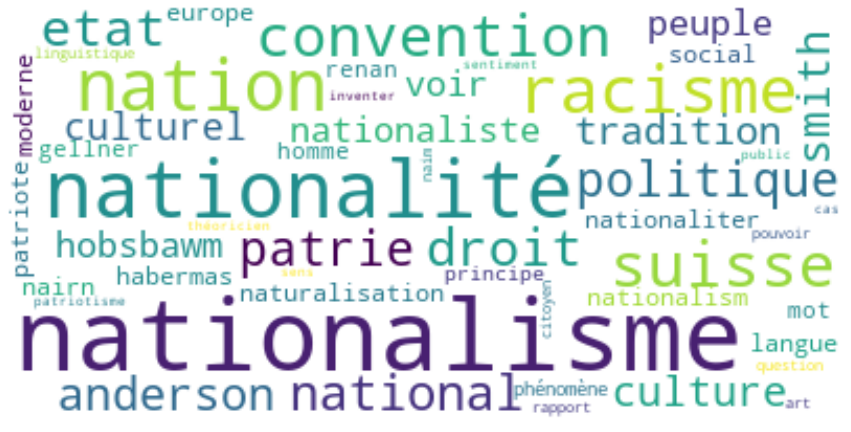

In [22]:
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[11][:50])
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

In [23]:
# Selected words:
#for word in term_list[:50]:
#    print(word)

In [24]:
def raw2counts(df):
    df = pd.DataFrame(df.data.values[0]).set_index("label")["items"].apply(pd.Series).stack().reset_index().drop("level_1", axis=1)
    df.columns = ["label", "data"]
    df = pd.concat([df, df["data"].apply(pd.Series)], axis=1).drop("data", axis=1)
    return df

In [25]:
# impresso results
trends_french = pd.read_json('./unigrams/unigrams_sociology_french.json', lines=True)
trends_french = raw2counts(trends_french)
trends_french = trends_french.groupby(pd.to_datetime(trends_french.date).dt.year//10).sum().reset_index()
trends_french

,date,value,total,ppm
0,179,4895,25056350,19272.765953
1,180,15504,84269750,56194.808633
2,181,30678,160446250,96612.938391
3,182,43328,249419900,85888.240482
4,183,58091,309818100,93452.545525
5,184,61981,335378650,92190.863623
6,185,115109,584440400,98162.554051
7,186,209072,972409050,107391.548531
8,187,274476,1362793850,100923.352667
9,188,329905,1657365600,99467.407131


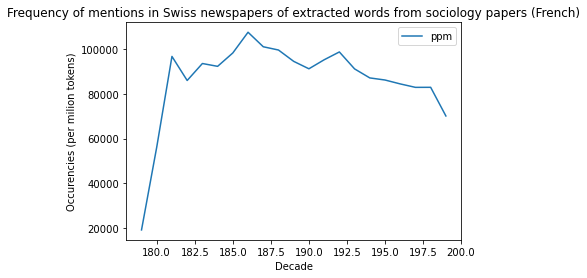

In [26]:
ax = trends_french.plot(x='date', y='ppm')
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of extracted words from sociology papers (French)")
plt.savefig("french.png", dpi=600)

In [27]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(german)
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==4]
swiss_tfidf=swiss_tfidf.T.sort_values(by=4, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:100])

['nation', 'nationalstaat', 'deutsch', 'nationalismus', 'national', 'europa', 'politisch', 'schweiz', 'staat', 'österreich', 'revolution', 'deutschland', 'jahrhundert', 'volk', 'nationsbildung', '19', 'geschichte', 'politische', 'reich', 'jahn', 'einheit', 'sängerbewegung', 'entstehen', 'krieg', 'schwäbisch', 'fremde', 'frankreich', 'europäisch', 'kulturell', 'gesellschaft', 'preuße', 'idee', 'deutsche', 'leben', 'bund', 'turnbewegung', 'lassen', 'modern', 'schweizer', 'alt', 'verein', 'turner', 'grenze', 'land', 'bewegung', 'müssen', 'gemeinsam', 'bilden', 'bleiben', 'ziel', 'nationalbewegung', 'stadt', 'gelten', 'zeigen', 'gehören', 'fest', 'schaffen', 'historisch', 'entwicklung', 'staatlich', 'preußisch', 'sprechen', 'sozial', 'mitglied', 'kraft', 'mensch', 'zuvor', 'gott', 'prozeß', 'territorium', 'militärisch', 'sänger', 'stark', 'stellen', 'tragen', 'kampf', 'weltkrieg', 'gegenwart', 'neu', 'nennen', 'bestimmen', 'religiös', 'vergangenheit', 'vorstellung', 'stehen', 'europäische'

In [30]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=4, ascending=False)

for i, w in enumerate(df.index):
    if i < 51:
        print(w, df[4][w])
    else:
        break

nation 0.4619357674595408
nationalstaat 0.3043913583470237
deutsch 0.22706586410497173
nationalismus 0.22659165014331156
national 0.1673820803167056
europa 0.1577053907137936
politisch 0.14133039466430006
schweiz 0.13024425302731213
staat 0.12710989571195572
österreich 0.11669956230556819
revolution 0.11475456960047539
deutschland 0.10290415832700188
jahrhundert 0.09588030926548384
volk 0.09238715349190815
nationsbildung 0.08946966443426896
19 0.08727314693555856
geschichte 0.08547044711665987
politische 0.08395262092724336
reich 0.08266218996644413
jahn 0.08071719726135133
einheit 0.07682721185116573
sängerbewegung 0.07585471549861932
entstehen 0.07061435405095236
krieg 0.06669133438145501
schwäbisch 0.0661297519731553
fremde 0.0661297519731553
frankreich 0.0661297519731553
europäisch 0.0643375225797566
kulturell 0.0641847592680625
gesellschaft 0.06348576200485945
preuße 0.0622397665629697
idee 0.061199106844158704
deutsche 0.06026762296687555
leben 0.059629898976359764
bund 0.0583497

In [35]:
# impresso results
trends_german = pd.read_json('./unigrams/unigrams_sociology_german.json', lines=True)
trends_german = raw2counts(trends_german)
trends_german = trends_german.groupby(pd.to_datetime(trends_german.date).dt.year//10).sum().reset_index()
trends_german

,date,value,total,ppm
0,178,29304,179905950,81352.067508
1,179,31677,237189450,68261.433197
2,180,39999,245521250,81506.761070
3,181,33054,262613250,63268.949410
4,182,56945,405449750,68578.008136
5,183,94567,578287200,81871.770549
6,184,181857,876938000,101745.382768
7,185,266305,1449802450,92648.625931
8,186,355508,2635705900,69161.918467
9,187,703363,4611242950,76917.515716


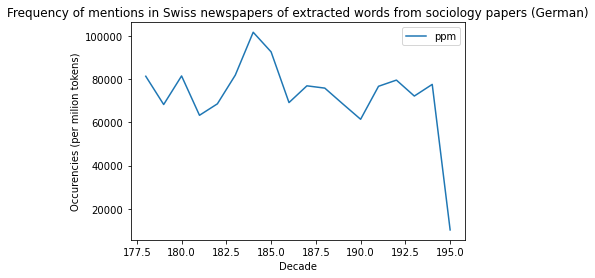

In [36]:
ax = trends_german.plot(x='date', y='ppm')
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of extracted words from sociology papers (German)")
plt.savefig("german.png", dpi=600)

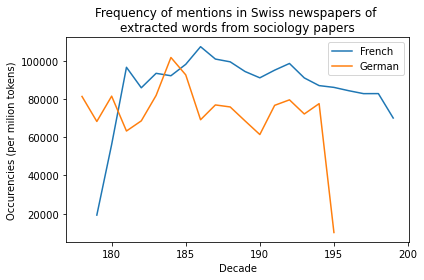

In [37]:
ax = trends_french.plot(x='date', y='ppm', label='French')
trends_german.plot(x='date', y='ppm', label='German', ax=ax)
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")

plt.tight_layout()
plt.savefig("both.png", dpi=600)

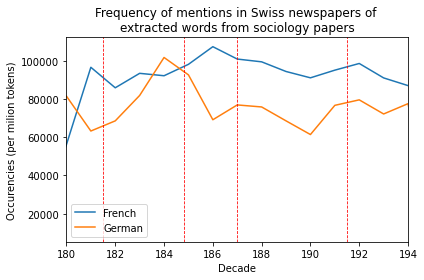

In [38]:
ax = trends_french.plot(x='date', y='ppm', label='French')
trends_german.plot(x='date', y='ppm', label='German', ax=ax)
xposition = [178.9, 181.5, 184.8, 187.0, 191.5]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--', linewidth=0.8)
    
ax.set_xlim((180,194))
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")

plt.tight_layout()
plt.savefig("both.png", dpi=600)

In [39]:
# normalization

rows = []
with open("normalization/nzz-counts.impresso", "r") as f:
    for line in f.readlines():
        rows.append(json.loads(line))
        
nzz_df = pd.DataFrame(rows[0][1][0])
nzz_df = nzz_df.buckets.apply(lambda row: pd.Series({'year': row['val'], 'article_count': row['count']}))
nzz_df = nzz_df.sort_values(by='year')
nzz_df = nzz_df.groupby(pd.to_datetime(nzz_df.year).dt.year//10).sum().reset_index()
 
trends_german['normalized_ppm'] = trends_german.total / nzz_df.article_count
trends_german

,date,value,total,ppm,normalized_ppm
0,178,29304,179905950,81352.067508,42753.315114
1,179,31677,237189450,68261.433197,49955.655013
2,180,39999,245521250,81506.761070,50045.097839
3,181,33054,262613250,63268.949410,59093.890639
4,182,56945,405449750,68578.008136,68907.163494
5,183,94567,578287200,81871.770549,100993.223891
6,184,181857,876938000,101745.382768,67675.412872
7,185,266305,1449802450,92648.625931,87723.267986
8,186,355508,2635705900,69161.918467,155178.445687
9,187,703363,4611242950,76917.515716,162356.275966


In [40]:
rows = []
with open("normalization/gdl-counts.impresso", "r") as f:
    for line in f.readlines():
        rows.append(json.loads(line))
        
        
gdl_df = pd.DataFrame(rows[0][1][0])
gdl_df = gdl_df.buckets.apply(lambda row: pd.Series({'year': row['val'], 'article_count': row['count']}))
gdl_df = gdl_df.sort_values(by='year')
gdl_df = gdl_df.groupby(pd.to_datetime(gdl_df.year).dt.year//10).sum().reset_index()
 
trends_french['normalized_ppm'] = trends_french.total / gdl_df.article_count
trends_french

,date,value,total,ppm,normalized_ppm
0,179,4895,25056350,19272.765953,9541.641280
1,180,15504,84269750,56194.808633,15476.538108
2,181,30678,160446250,96612.938391,28992.817130
3,182,43328,249419900,85888.240482,30115.901956
4,183,58091,309818100,93452.545525,27561.435815
5,184,61981,335378650,92190.863623,21668.086962
6,185,115109,584440400,98162.554051,12139.171254
7,186,209072,972409050,107391.548531,11369.083139
8,187,274476,1362793850,100923.352667,10246.647343
9,188,329905,1657365600,99467.407131,10437.139708


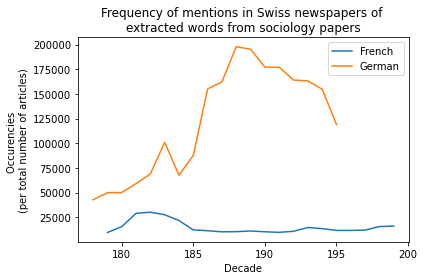

In [41]:
ax = trends_french.plot(x='date', y='normalized_ppm', label='French')
trends_german.plot(x='date', y='normalized_ppm', label='German', ax=ax)
ax.set_ylabel("Occurencies \n(per total number of articles)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")

plt.tight_layout()
plt.savefig("both_normalized.png", dpi=600)

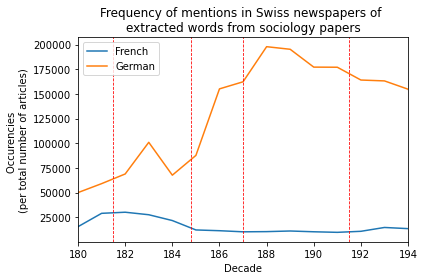

In [42]:
ax = trends_french.plot(x='date', y='normalized_ppm', label='French')
trends_german.plot(x='date', y='normalized_ppm', label='German', ax=ax)
xposition = [178.9, 181.5, 184.8, 187.0, 191.5]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--', linewidth=0.8)
    
ax.set_xlim((180,194))
ax.set_ylabel("Occurencies \n(per total number of articles)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")

plt.tight_layout()
plt.savefig("both_normalized.png", dpi=600)

In [43]:
vectorizer = TfidfVectorizer(ngram_range=(2,4))
X = vectorizer.fit_transform(french[:12])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==11]
swiss_tfidf= swiss_tfidf.T.sort_values(by=11, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
mapping = {}
for i,f_name in enumerate(feature_names):
    mapping[i] = f_name
print(term_list[:30])

['racisme nationalisme', 'droit nationalité', 'théorie nationalisme', 'convention nationalité', 'théoricien nationalisme', 'tradition inventer', 'convention européen', 'droit homme', 'art convention', 'mot patrie', 'nationalisme racisme', 'articulation racisme', 'articulation racisme nationalisme', 'lien racisme', 'lien racisme nationalisme', 'convention européen nationalité', 'invention tradition', 'européen nationalité', 'naturalisation ordinaire', 'explicatif convention européen', 'art let', 'rapport explicatif convention européen', 'rapport explicatif convention', 'rapport explicatif', 'nationalité droit', 'explicatif convention', 'droit international', 'nationalité numéro', 'nation moderne', 'mot nation']


In [44]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=11, ascending=False)

for i, w in enumerate(df.index):
    if i < 51:
        print(w, df[11][w])
    else:
        break

racisme nationalisme 0.25009928771891965
droit nationalité 0.135188804172389
théorie nationalisme 0.11040419007411767
convention nationalité 0.08787272271205285
théoricien nationalisme 0.08336642923963987
tradition inventer 0.0675944020861945
convention européen 0.06534125534998801
droit homme 0.06324484640723482
art convention 0.06308810861378153
mot patrie 0.06083496187757505
nationalisme racisme 0.06083496187757505
articulation racisme 0.056328668405162076
articulation racisme nationalisme 0.056328668405162076
lien racisme 0.04956922819654263
lien racisme nationalisme 0.04731608146033615
convention européen nationalité 0.04731608146033615
invention tradition 0.04731608146033615
européen nationalité 0.04731608146033615
naturalisation ordinaire 0.04280978798792318
explicatif convention européen 0.04280978798792318
art let 0.04280978798792318
rapport explicatif convention européen 0.04280978798792318
rapport explicatif convention 0.04280978798792318
rapport explicatif 0.042809787987923

In [45]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=11, ascending=False)
print(df[11])

racisme nationalisme                   0.250099
droit nationalité                      0.135189
théorie nationalisme                   0.110404
convention nationalité                 0.087873
théoricien nationalisme                0.083366
                                         ...   
impossible thi content                 0.000000
impossible thi content downloaded      0.000000
impostur scientifique                  0.000000
impostur scientifique constitue        0.000000
légitimer thème implanter récemment    0.000000
Name: 11, Length: 260253, dtype: float64


In [46]:
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[11][:50])

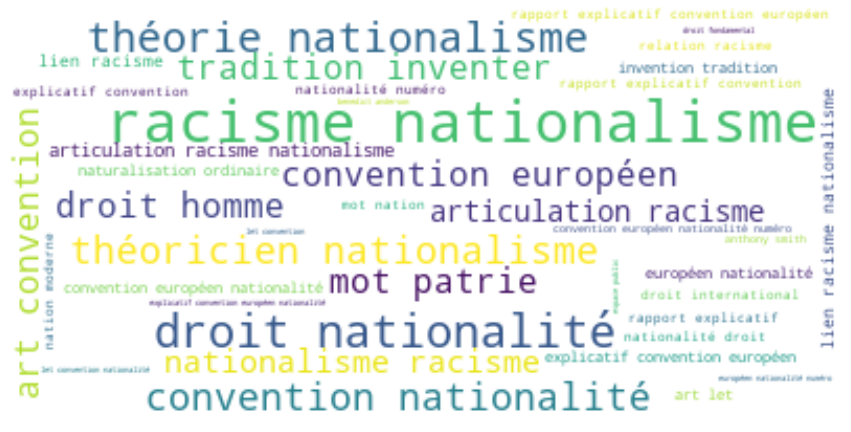

In [47]:
# display the word cloud
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

In [48]:
vectorizer = TfidfVectorizer(ngram_range=(2,4))
X = vectorizer.fit_transform(german)
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==4]
swiss_tfidf=swiss_tfidf.T.sort_values(by=4, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:30])

['deutsch nation', '19 jahrhundert', 'deutsch nationalstaat', 'deutsche bund', 'deutsch staat', 'nation nationalstaat', 'deutsch geschichte', 'hälfte 19 jahrhundert', 'modern nationalismus', 'hälfte 19', 'schwäbisch sängerbewegung', 'deutsch nationalbewegung', '18 jahrhundert', 'prozeß nationsbildung', 'idee nation', 'schwäbische sängerbewegung', 'national bewegung', 'modern nation', '20 jahrhundert', 'französische revolution', 'alte reich', 'deutsch sängerbewegung', 'schwäbisch sängerbund', 'schwäbische sängerbundes', 'deutsch volk', 'spät 18', 'idee deutsch', 'partizipation aggression', 'kleindeutschen nationalstaat', 'staat gesellschaft']


In [49]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=4, ascending=False)

for i, w in enumerate(df.index):
    if i < 51:
        print(w, df[4][w])
    else:
        break

deutsch nation 0.19039979122034115
19 jahrhundert 0.18791383461734723
deutsch nationalstaat 0.11023145807493434
deutsche bund 0.1002104164317585
deutsch staat 0.08517885396699472
nation nationalstaat 0.07014729150223094
deutsch geschichte 0.0667005347258678
hälfte 19 jahrhundert 0.0601262498590551
modern nationalismus 0.0601262498590551
hälfte 19 0.0601262498590551
schwäbisch sängerbewegung 0.057620989448261134
deutsch nationalbewegung 0.05511572903746717
18 jahrhundert 0.04509468739429132
prozeß nationsbildung 0.04509468739429132
idee nation 0.04258942698349736
schwäbische sängerbewegung 0.040084166572703396
national bewegung 0.040084166572703396
modern nation 0.03757890616190943
20 jahrhundert 0.03436088152544705
französische revolution 0.03256838534032151
alte reich 0.03006312492952755
deutsch sängerbewegung 0.027557864518733585
schwäbisch sängerbund 0.027557864518733585
schwäbische sängerbundes 0.027557864518733585
deutsch volk 0.025052604107939625
spät 18 0.025052604107939625
idee

deutsch nation                            0.190400
19 jahrhundert                            0.187914
deutsch nationalstaat                     0.110231
deutsche bund                             0.100210
deutsch staat                             0.085179
                                            ...   
nehmen programmatik soziologie private    0.000000
nehmen programmatik soziologie            0.000000
nehmen programmatik                       0.000000
nehmen karl popper ausdrücken             0.000000
lebensführung soziologie                  0.000000
Name: 4, Length: 143428, dtype: float64


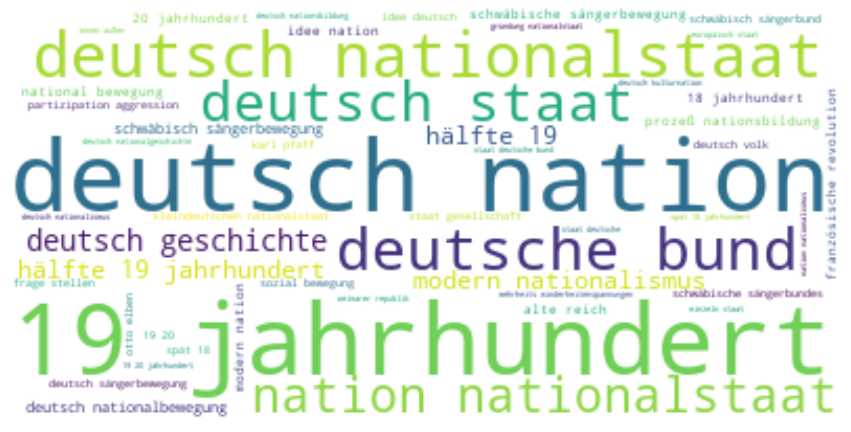

In [25]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=4, ascending=False)
print(df[4])
Cloud = wordcloud.WordCloud(background_color="white", max_words=50).generate_from_frequencies(df[4][:50])
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

In [30]:
# only swiss vs general nationality          
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(french_txt_sw[:11])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==10]
swiss_tfidf= swiss_tfidf.T.sort_values(by=10, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:100])

['nationalité', 'convention', 'droit', 'etat', 'art', 'naturalisation', 'suisse', 'nationaliter', 'numéro', 'international', 'voir', 'infra', 'fédéral', 'matière', 'paul', 'cour', 'françois', 'également', 'chapitre', 'européen', 'procédure', 'acquisition', 'général', 'apatridie', 'henri', 'ordinaire', 'domaine', 'traité', 'prévoir', 'recueil', 'juridique', 'rs', 'let', 'explicatif', 'batiffol', 'compétence', 'monsieur', 'relatif', 'homme', 'étranger', 'avril', 'règle', 'borella', 'citoyenneté', 'entrer', 'cas', 'lagarde', 'perte', 'obligation', 'rapport', 'théorie', 'titre', 'militaire', 'conseil', 'ratifier', 'rezek', 'haye', 'francisco', 'immer', 'décembre', 'décision', 'vigueur', 'réglementation', 'apatride', 'chan', 'johannes', 'ressortissant', 'tribunal', 'protocole', 'disposition', 'loi', 'coutumier', 'principe', 'terme', 'pierre', 'vol', 'femme', 'hélène', 'jacques', 'kotalakidi', 'weis', 'roland', 'alexander', 'justice', 'enfant', 'condition', 'national', 'manière', 'législatio

In [34]:
# only swiss vs general nationality          
vectorizer = TfidfVectorizer(ngram_range=(2,4))
X = vectorizer.fit_transform(french_txt_sw[:11])
df_tfidf = pd.DataFrame(X.toarray())
swiss_tfidf = df_tfidf[df_tfidf.index==10]
swiss_tfidf= swiss_tfidf.T.sort_values(by=10, ascending=False)


swiss_indexes = swiss_tfidf.index
feature_names = vectorizer.get_feature_names()
term_list = [feature_names[i] for i in swiss_indexes]
print(term_list[:30])

['droit nationalité', 'convention nationalité', 'convention européen', 'art convention', 'convention européen nationalité', 'européen nationalité', 'rapport explicatif convention', 'rapport explicatif', 'naturalisation ordinaire', 'explicatif convention européen', 'explicatif convention', 'nationalité droit', 'art let', 'rapport explicatif convention européen', 'droit homme', 'droit international', 'nationalité numéro', 'européen nationalité numéro', 'convention européen nationalité numéro', 'explicatif convention européen nationalité', 'art let convention nationalité', 'art convention nationalité', 'let convention nationalité', 'procédure naturalisation', 'batiffol henri', 'art let convention', 'let convention', 'général droit', 'nationalité art', 'borella françois']


nationalité       0.574738
convention        0.323440
droit             0.303850
etat              0.170643
art               0.167200
                    ...   
fomenter          0.000000
foll              0.000000
folkloriste       0.000000
folklorisation    0.000000
œuvrer            0.000000
Name: 10, Length: 9594, dtype: float64


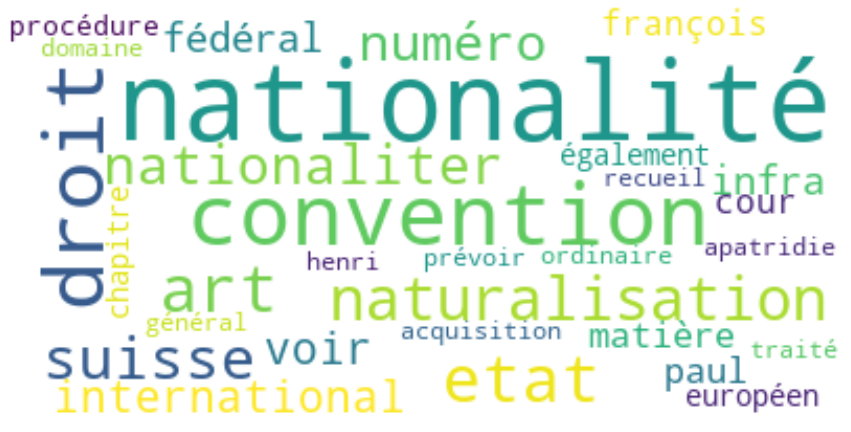

In [31]:
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names).T.sort_values(by=10, ascending=False)
print(df[10])
Cloud = wordcloud.WordCloud(background_color="white", max_words=30).generate_from_frequencies(df[10][:50])
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Cloud, interpolation='bilinear')
#plt.tight_layout()
plt.axis('off')
plt.show()

### Words French:
outliers: voir (see), sens (meaning), inventer (invent), tradition inventer (inventing tradition),
interesting: naturalisation (naturalization), nationalité droit (nationality law),

**invention of tradition** The concept was highlighted in the 1983 book The Invention of Tradition, edited by Eric Hobsbawm and Terence Ranger. Hobsbawm's introduction argues that many "traditions" which "appear or claim to be old are often quite recent in origin and sometimes invented." This "invention" is distinguished from "starting" or "initiating" a tradition which does not then claim to be old. The phenomenon is particularly clear in the modern development of the nation and of nationalism, creating a national identity promoting national unity, and legitimising certain institutions or cultural practices.

The concept was influential on the use of related concepts, such as Benedict Anderson's imagined communities and the pizza effect.

One implication of the term is that the sharp distinction between "tradition" and "modernity" is often itself invented. The concept is "highly relevant to that comparatively recent historical innovation, the 'nation,' with its associated phenomena: nationalism, the nation-state, national symbols, histories, and the rest." Hobsbawm and Ranger remark on the "curious but understandable paradox: modern nations and all their impedimenta generally claim to be the opposite of novel, namely rooted in remotest antiquity, and the opposite of constructed, namely human communities so 'natural' as to require no definition other than self-assertion." Another implication is that the concept of "authenticity" is also to be questioned.

**nationality law and statelessness** De jure vs de facto statelessness
Nationality law defines citizenship and statelessness. Citizenship is awarded based on two well-known principles: jus sanguinis and jus soli. Jus sanguinis translated from Latin means "right of blood." According to this principle, citizenship is awarded if the parent(s) of the person are citizens of that country. Jus soli is referred to as "birthright citizenship." It means, anyone born in the territory of the country is awarded citizenship of that country.

Statelessness person is defined by 1954 Statelessness Convention as "a person who is not considered a national by any State under operation of its law.” A person can become stateless because of administrative reasons. For example, "A person may be at risk of statelessness if she is born in a State that applies jus sanguinis while her parents were born in a State that applies jus soli, leaving the person ineligible for citizenship in both States due to conflicting laws." Moreover, there are countries in which if a person doesn't reside for a specified period of time, they can automatically lose their nationality. To protect those individuals from being deemed "stateless," 1961 Statelessness Convention places limitations on nationality laws. See 1961 Statelessness Convention, arts. 6-8.


#### Words only on Swiss case:
convention (convention), apatridie (statelessness), réglementation (regulation),

**Swiss regulation**
Swiss citizenship is the status of being a citizen of Switzerland and it can be obtained by birth or naturalisation.

The Swiss Citizenship Law is based on the following principles:

Triple citizenship level (Swiss Confederation, canton, and municipality)
Acquisition of citizenship through descent (jus sanguinis)
Prevention of statelessness
Swiss nationals are citizens of their municipality of origin, their canton of origin, and the Confederation, in that order: a Swiss citizen is defined as someone who has the bourgeoisie of a Swiss municipality (article 37 of the Swiss Federal Constitution). They are entered in the family register of their place of origin. The manner by which Swiss citizens acquire their place of origin differs depending on whether they acquired Swiss citizenship by filiation (jus sanguinis), ordinary naturalisation, or facilitated naturalisation. Marriage has in and of itself no effect on the places of origin of the spouses.

**Naturalization**
In addition to the aforementioned formal conditions, the federal nationality law of 2014 also imposes material conditions which an applicant for naturalisation must meet:[19]

The applicant must be well integrated,
The applicant must be familiar with life in Switzerland,
The applicant must not endanger Switzerland's interior or exterior security,
The applicant must show respect for public order and security,
The applicant must respect the values of the federal constitution,
The applicant must be able to communicate in a national language, both orally and in writing,
The applicant must participate in the economy or be in education,
The applicant must, if married, in a registered partnership, or a parent, encourage and support the integration of his or her spouse and/or minor children



#### General topics
communauté (community), commun (common), populisme (populism), 
étranger (foreign)
people (Anderson, Johannes)

### Words German:
outliers: sängerbewegung (singers movement), turnbewegung (gymnastics), schwäbisch sängerbewegung (Swabian singer movement),
interesting: nationsbildung (nation formation), grenze (border), staat gesellschaft (state society)

#### General topics
volk (people), einheit (unity), 
militärisch (military)
half of the 19th century, 20th century, French Revolution

### Narrative

From the French version, attention towards the idea that nation is invented, act of seeing, action of a community
Specifically Swiss, concept of regulation of nationality, from statelessness to naturalization
From the German version, temporal attention, lots of military stuff, singers and gymnasts, nationsbildung

In [29]:
# TODO: which words are drivers in the longitudinal plot
#       how the chosen words are used in context

word meanings, evolution, history,
how some of the words are good, what topic it represents, shit, super noisy, if used by some author, how the word was born, --> examples of where it was used, reconnect to context, 
1-2 unexpected cases,
temporal: normalization, which words are the drivers, how specific, how broad, something that happened that years, or how later/before it happens 
convey clear narrative, acknowledge the bias, 
arguments, convincing reason,
how limited to the specific topic of the paper the extraction is (ie racisme)


nationsbildung vs inventer nationalité, più astratto, filosofia posthegeliana meno messa in discussione, Fichte, sviluppo socialista, vs Rousseau, spezzata, partigiana.

proiezione su stati vicini



### Other plots

In [ ]:
french_bigrams = (pd.Series(nltk.ngrams(' '.join(french_txt_sw).split(), 2)).value_counts())[:30]
french_trigrams = (pd.Series(nltk.ngrams(' '.join(french_txt_sw).split(), 3)).value_counts())[:30]

In [ ]:
french_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
french_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [ ]:
german_bigrams = (pd.Series(nltk.ngrams(' '.join(german_txt_sw).split(), 2)).value_counts())[:40]
german_trigrams = (pd.Series(nltk.ngrams(' '.join(german_txt_sw).split(), 3)).value_counts())[:35]

In [ ]:
german_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
german_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

### Trying out some LDA to get only words related to topic nationality

In [ ]:
french_tokens = [tokenizer.tokenize(french) for french in french_txt_sw]
# Create Dictionary
id2word = corpora.Dictionary(french_tokens)
# Create Corpus
texts = french_tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

In [ ]:
for index, topic in lda_model.show_topics(formatted=False, num_words=40):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

In [ ]:
german_tokens = [tokenizer.tokenize(german) for german in german_txt_sw]
# Create Dictionary
id2word = corpora.Dictionary(german_tokens)
# Create Corpus
texts = german_tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

In [ ]:
for index, topic in lda_model.show_topics(formatted=False, num_words=40):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))